# An example of the Nonlinear inference with multiple latent functions.

This notebook briefly shows an example for an inverse problem where multiple latent functions to be infered.

*Keisuke Fujii 3rd Oct. 2016*

## Synthetic observation

Consider we observe a cylindrical transparent mediam with multiple ($N$) lines-of-sight, as shown below.

<img src=figs/abel_inversion.png width=240pt> 
<img src=figs/los_theta.png width=180pt>
   
The local emission intensity $a(r)$, local flow velocity $v(r)$, and local temperature $\sigma(r)$ are functions of radius $r$.,

The local spectrum $\\mathbf{y}_{i,j}$ from $i$-th shell with radius $r_i$  measured with the $j$-th sight line can be written as,
$$
\mathbf{y}_{i,j} = \frac{a(r_i)}{\sqrt{2\pi}\sigma_i}\exp\left[ 
\frac{(\lambda-\lambda_0 v_i/c \cos\theta_{i,j})^2}{2\sigma_i^2}  
\right]
+ \mathbf{e}_i
$$
where $\theta_{i,j}$ is an angle between the $i$-th shell and $j$-th sight line.
$\mathbf{e}$ is i.i.d. Gaussian noise.

## Non-linear model and transform


We assume $\log \mathbf{a}$, $\mathbf{v}$, $\log \mathbf{\sigma}$ follow Gaussian process,
with the identical kernel $\mathrm{K_a}$, $\mathrm{K_v}$, $\mathrm{K_\sigma}$, respecvitvely.

In this notebook, we infer $\mathbf{a},\mathbf{v},\mathbf{\sigma},$ by 
1. Stochastic approximation of the variational Gaussian process.
2. Markov Chain Monte-Carlo (MCMC) method.

## Import several libraries including GPinv

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
import sys
# In ../testing/ dir, we prepared a small script for generating the above matrix A
sys.path.append('../testing/')
import make_LosMatrix
# Import GPinv
import GPinv

## Synthetic signals

Here, we make a synthetic measurement.
The synthetic signal $\mathrm{y}$ is simulated from the grand truth solution $g_true$ and random gaussian noise.

In [2]:
n = 30 # radial coordinate 
N = 40 # number of cite lines
# radial coordinate
r = np.linspace(0, 1., n)
# synthetic latent function
a = np.exp(-(r-0.3)*(r-0.3)/0.1) + np.exp(-(r+0.3)*(r+0.3)/0.1)
v = 3.*np.exp(-(r-0.6)*(r-0.6)/0.05)*(r-0.6)
sigma = 1.*np.exp(-(r-0.0)*(r-0.0)/0.3) + 0.2

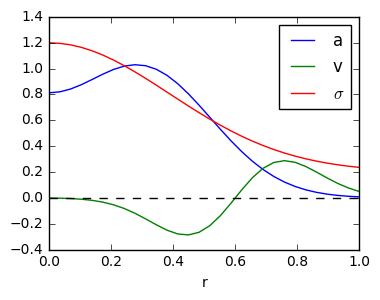

In [3]:
# plotting the latent function
plt.figure(figsize=(4,3))
plt.plot(r, a, label='a')
plt.plot(r, v, label='v')
plt.plot(r, sigma, label='$\sigma$')
plt.plot([0,1], [0,0], '--k')
plt.xlabel('r')
plt.legend()

### Prepare the synthetic signal.

In [4]:
# los height
z = np.linspace(-0.9,0.9, N)
# Los-matrix
A = make_LosMatrix.make_LosMatrix(r, z)
cosTheta = make_LosMatrix.make_cosTheta(r,z)
print(A.shape, cosTheta.shape)

(40, 30) (40, 30)


In [5]:
# Wavelength coordinate
# number of coordinate
m = 50
# coordinate 
lam = np.linspace(-3,3,50)

In [6]:
# true (synthetic) signals.
f_true = np.zeros((m, N, n))
for i in range(N):
    for j in range(n):
        f_true[:,i,j] = a[j] / (np.sqrt(2*np.pi)*sigma[j]) * np.exp(-0.5*((lam-v[j]*cosTheta[i,j])/sigma[j])**2)

In [7]:
# synthetic observation
y_syn = np.zeros((m,N))
for i in range(N):
    for j in range(n):
        y_syn[:,i] += A[i,j] * f_true[:,i,j]
y_syn+=np.random.randn(m,N)*0.02

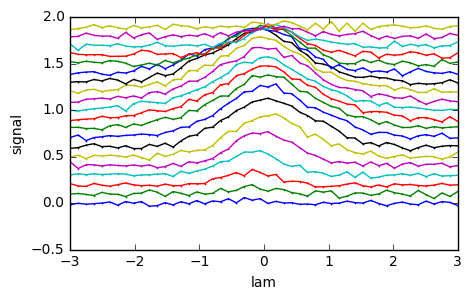

In [8]:
# plot
plt.figure(figsize=(5,3))
for i in range(0,N,2):
    plt.plot(lam, y_syn[:,i]+0.05*i, '-+', ms=2)
plt.xlabel('lam')
plt.ylabel('signal')

# Inference

In order to carry out an inference, a custom **likelihood**, which calculates $p(\mathbf{Y}|\mathbf{f})$ with given $\mathbf{f}$, must be prepared according to the problem.

The method to be implemented is **logp(f,Y)** method, that calculates log-likelihood for data **Y** with given **f**

In [9]:
class SpecAbelLikelihood(GPinv.likelihoods.Likelihood):
    def __init__(self, Amat, cosTheta, lam):
        GPinv.likelihoods.Likelihood.__init__(self)
        # Amat, cosTheta shape [m,n]
        self.Amat = GPinv.param.DataHolder(Amat)
        self.cosT = GPinv.param.DataHolder(cosTheta)
        # lam [k,1]
        self.lam = GPinv.param.DataHolder(lam.reshape(-1,1))
        self.variance = GPinv.param.Param(np.ones(1), GPinv.transforms.positive)
    
    def sample_F(self, F):
        """
        :param tf.tensor F: sized [N,n,R]
        :return tf.tensor Transformed F: sized [N,k,m]
        where N is number of samples to approximate integration.
              n is number of radial coordinate,
              R is number of latent functions (a, sigma, v),
              k is number of wavelength points
              m is number of citelines.
        """
        N = tf.shape(F)[0]
        n = tf.shape(F)[1]
        k = tf.shape(self.lam)[0]
        m = tf.shape(self.Amat)[0]
        # latent functions
        a, s, v = tf.unpack(F, axis=-1, num=3) # shape [N,n]
        # map a and s by exp
        a = tf.exp(a)
        s = tf.exp(s)
        # Tile latent functions to be sized [N,k,m,n]
        a    = tf.tile(tf.expand_dims(tf.expand_dims(a, 1),-2), [1,k,m,1])
        s    = tf.tile(tf.expand_dims(tf.expand_dims(s, 1),-2), [1,k,m,1])
        v    = tf.tile(tf.expand_dims(tf.expand_dims(v, 1),-2), [1,k,m,1])
        Amat = tf.tile(tf.expand_dims(tf.expand_dims(self.Amat,0), 0), [N,k,1,1])
        cosT = tf.tile(tf.expand_dims(tf.expand_dims(self.cosT,0), 0), [N,k,1,1])
        lam  = tf.tile(tf.expand_dims(tf.expand_dims(self.lam, 0),-1), [N,1,m,n])
        # Latent spectrum at wavelength k, radial position n, cite line m
        f = a / (np.sqrt(2*np.pi)*s) * tf.exp(-0.5*tf.square((lam - v * cosTheta)/s))
        # Latent spectrum at wavelength k, cite line m, [N,k,m]
        Af = tf.reduce_sum(Amat * f, 3)
        return Af
        
    def logp(self, F, Y):
        """
        :param tf.tensor Y: sized [k,m]
        :return tf.tensor : tensor containing logp values.
        """
        # Expand Y to shape [N,k,m]
        f_samples = self.sample_F(F)
        Y = tf.tile(tf.expand_dims(Y, 0), [tf.shape(f_samples)[0],1,1])
        return GPinv.densities.gaussian(f_samples, Y, self.variance)

In [10]:
lik = SpecAbelLikelihood(A, cosTheta, lam)

### Kernel

The statistical property is interpreted in Gaussian Process kernel.

Since $a$ and $s$ are cylindrically symmetric functions,
we adopt **RBF_csym** kernel for $\mathbf{K}_a$ and $\mathbf{K}_s$ with **same** lengthscale.

Since $v$ is a cylindrically anti-symmetric functions, we adopt **RBF_casym** kernel for $\mathbf{K}_v$.

In [11]:
# kernel for a and s
kern_as = GPinv.kernels.RBF_csym(1, 2)
kern_as.lengthscales = 0.3
# kernel for v
kern_v = GPinv.kernels.RBF_casym(1, 1)
kern_v.lengthscales = 0.3
# Stacked kernel
kern = GPinv.kernels.Stack([kern_as, kern_v])

### MeanFunction

To make $a$ and $s$ scale invariant, we added the constant mean_function for them.
We adopt a zero mean for $v$

In [12]:
# mean for a and s
mean_as = GPinv.mean_functions.Constant(2, c=np.ones(2)*(-2))
# mean for v
mean_v  = GPinv.mean_functions.Zero(1)
# Stacked mean
mean = GPinv.mean_functions.Stack([mean_as, mean_v])

## Variational inference by StVGP

In StVGP, we evaluate the posterior $p(\mathbf{f}|\mathbf{y},\theta)$ by approximating as a multivariate Gaussian distribution.

The hyperparameters are obtained at the maximum of the evidence lower bound (ELBO) $p(\mathbf{y}|\theta)$.

In [13]:
model_stvgp = GPinv.stvgp.StVGP(r.reshape(-1,1), y_syn, 
                                kern = kern, mean_function = mean,likelihood=lik,
                                num_latent=3, num_samples=5)

## Draw the initial estimate.

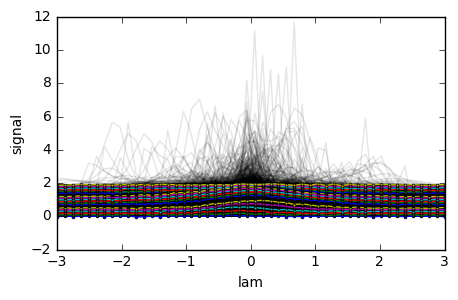

In [14]:
# Data Y should scatter around the transform F of the GP function f.
sample_F = model_stvgp.sample_F(100)
plt.figure(figsize=(5,3))
# initial estimate
for s in sample_F:
    for i in range(0,N,2):
        plt.plot(lam, s[:,i]+0.05*i, '-k',lw=1, alpha=0.1)
# observation
for i in range(0,N,2):
    plt.plot(lam, y_syn[:,i]+0.05*i, '-o', ms=2)
# plot
plt.xlabel('lam')
plt.ylabel('signal')

Although the initial estimate does not seem good, we start from here.

## Iteration

In [15]:
# This function visualizes the iteration.
from IPython import display

logf = []
def logger(x):
    if (logger.i % 10) == 0:
        obj = -model_stvgp._objective(x)[0]
        logf.append(obj)
        # display
        if (logger.i % 100) ==0:
            plt.clf()
            plt.plot(logf, '--ko', markersize=3, linewidth=1)
            plt.ylabel('ELBO')
            plt.xlabel('iteration')
            display.display(plt.gcf())
            display.clear_output(wait=True)
    logger.i+=1
logger.i = 1

Ellapsed Time is 128.35459208488464  (s)


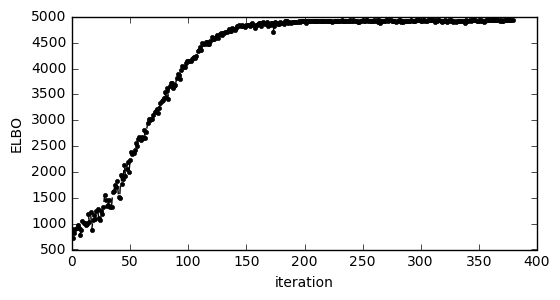

In [16]:
import time
# start time
start_time = time.time()

plt.figure(figsize=(6,3))
# Rough optimization by scipy.minimize
model_stvgp.optimize()
# Final optimization by tf.train
trainer = tf.train.AdamOptimizer(learning_rate=0.003)
_= model_stvgp.optimize(trainer, maxiter=5000, callback=logger)

display.clear_output(wait=True)

print('Ellapsed Time is', time.time()-start_time, ' (s)')

## Plot the result

## Latent function

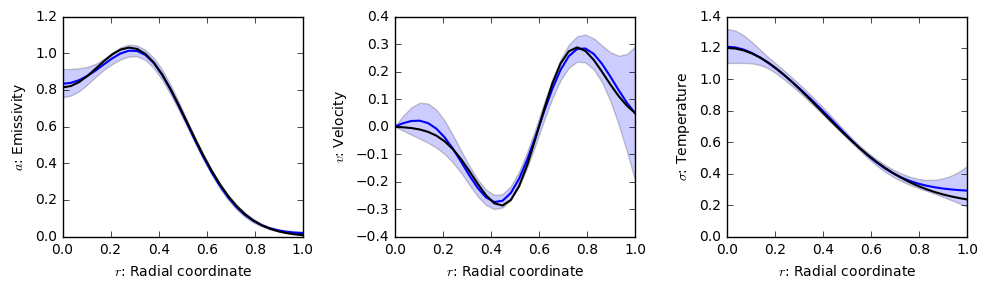

In [17]:
r_new = np.linspace(0.,1., 30)
plt.figure(figsize=(10,3))

# --- StVGP ---
f_pred, f_var = model_stvgp.predict_f(r_new.reshape(-1,1))
f_plus  = f_pred + 2.*np.sqrt(f_var)
f_minus = f_pred - 2.*np.sqrt(f_var)

# --- observed and grand truth ---
plt.subplot(1,3,1)
plt.fill_between(r_new, np.exp(f_plus[:,0]), np.exp(f_minus[:,0]), alpha=0.2)
plt.plot(r_new, np.exp(f_pred[:,0]), label='StVGP',lw=1.5)
plt.plot(r, a, '-k', label='true',lw=1.5)
plt.xlabel('$r$: Radial coordinate')
plt.ylabel('$a$: Emissivity')

plt.subplot(1,3,2)
plt.fill_between(r_new, f_plus[:,2], f_minus[:,2], alpha=0.2)
plt.plot(r_new, f_pred[:,2], label='StVGP',lw=1.5)
plt.plot(r, v, '-k', label='true',lw=1.5)
plt.xlabel('$r$: Radial coordinate')
plt.ylabel('$v$: Velocity')

plt.subplot(1,3,3)
plt.fill_between(r_new, np.exp(f_plus[:,1]), np.exp(f_minus[:,1]), alpha=0.2)
plt.plot(r_new, np.exp(f_pred[:,1]), label='StVGP',lw=1.5)
plt.plot(r, sigma, '-k', label='true',lw=1.5)
plt.xlabel('$r$: Radial coordinate')
plt.ylabel('$\sigma$: Temperature')

plt.tight_layout()

## Transformed functions

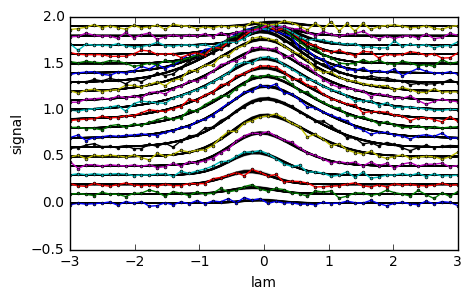

In [18]:
# Data Y should scatter around the transform F of the GP function f.
sample_F = model_stvgp.sample_F(100)
plt.figure(figsize=(5,3))
# initial estimate
for s in sample_F:
    for i in range(0,N,2):
        plt.plot(lam, s[:,i]+0.05*i, '-k', lw=1, alpha=0.1)
# observation
for i in range(0,N,2):
    plt.plot(lam, y_syn[:,i]+0.05*i, '-o', ms=2)
plt.xlabel('lam')
plt.ylabel('signal')